# Comeco

In [500]:
import pandas as pd
import os
import shutil

import re
import cv2
import fitz  # Módulo PyMuPDF
from PIL import Image
from PIL import ImageFont
from PIL import Image, ImageDraw

import pytesseract

import modules.extrai_pdf_pesquisavel as Extc
import modules.cronometro as cron

In [501]:
#Config Basico

i_test = 17

### PRESTAR ATENCAO
#model = 'mage'
#model = 'mesquita'
model = 'pedro_aldeia'


# Nome Batch
batch_name_format = "Batch_" + str(i_test)

root_doc_analise = "pipeline_extracao_documentos/2_documentos_para_extracao"

image_resized_path = "pipeline_extracao_documentos/6_geral_administacao/images/processadas"

batch_processado_ok_path = "pipeline_extracao_documentos/5_documentos_processados/Batcher_processados_ok"

## 1. Criacao processo dfs e operacoes basicas com arquivos

### Processamento Pipeline

In [502]:
    
def is_pdf_searchable_analise(pdf_path):
    try:
        pdf_document = fitz.open(pdf_path)
        pages = pdf_document.page_count
        is_searchable = all(page.get_text("text") != "" for page in pdf_document)
        dados_pdf = pdf_document.metadata
        pdf_document.close()
        return is_searchable, dados_pdf, pages
    except Exception as e:
        print(f"Erro ao verificar o PDF: {file_path} {e}")
        return False    


In [503]:
def move_folder(src_folder, dest_folder):
    shutil.move(src_folder, dest_folder)

In [504]:
def move_processed_files(df, dest_folder, status_file):
    for index, row in df.iterrows():
        orig_path = row['file_path']
        dest_path = os.path.join(dest_folder, row['nome_arquivo_destino'])
        
        #print(f"Origem: {orig_path}")
        #print(f"Destino: {dest_path}")
        
        ultimo_nivel = os.path.basename(destino)

        shutil.move(orig_path, dest_path)
        df.at[index, 'status'] = status_file
        df.at[index, 'dest_folder'] = ultimo_nivel


In [510]:
def confirma_pdf_pequisavel3(file_path):
    
    pdf_document = fitz.open(file_path)
    # Página do PDF  ATENCAO  (UNICA PAGINA)
    page_number = 0  # Defina o número da página que deseja analisar
    page = pdf_document[page_number]
    # Definir retângulo de interesse
    x0 = 0
    y0 = 4
    x1 = 600
    y1 = 200  # Ajuste este valor para delimitar a região vertical
    # Extrair texto dentro do retângulo
    text = page.get_text("text", clip=(x0, y0, x1, y1))
    if text:
       page_number = 0
       pdf_realmente_pequisavel = True
       #print(page_number)
    else:
       page_number = 1
       pdf_realmente_pequisavel = False
       #print(page_number)
    
    try:
        page = pdf_document[page_number]
        x0 = 0
        y0 = 0
        x1 = 600
        y1 = 110

        text = page.get_text("text", clip=(x0, y0, x1, y1))
        nf_data_cabecalho = Extc.extract_fields_cabecalho(text)
        
        if nf_data_cabecalho:
            pdf_realmente_pequisavel = True
        else:
            pdf_realmente_pequisavel = False
            
      
        return pdf_realmente_pequisavel, page_number
    except Exception as e:
        print(f"Erro ao abrir pagina do PDF: {e}")
        return pdf_realmente_pequisavel, page_number
    pdf_document.close()   

### 1. Funcao principal de iteracao e processamento

In [520]:
def process_file(file_path, batch_name, folder_name):
    
    # IMPORTANTE: Coloque aqui sua lógica para cada arquivo
    time_now = cron.timenow_pt_BR()
    pesquisavel, metadados, paginas = is_pdf_searchable_analise(file_path)
    tipo_pdf = "NFe"
    dest_folder = 'processados'
    nome_arq_ori = os.path.basename(file_path)
    nome_arq_det = os.path.basename(file_path)
    dest_dir = os.path.join(dest_folder, nome_arq_det)
    #real_pesquisavel, paginas = confirma_pdf_pequisavel3(file_path)
    
    #status_pro = '...'
    return {
        'data_processamento': time_now,
        'Batch': batch_name,
        'diretorio_origem': folder_name,
        'nome_arquivo_origem': nome_arq_ori,
        'nome_arquivo_destino': nome_arq_det,
        'status': "..",
        'dest_folder': dest_folder,
        'tipo_pdf': tipo_pdf,
        'qut_paginas': paginas,
        'file_path': file_path
    }

In [532]:
def process_email(file_path, batch_name, folder_name):
    
    # IMPORTANTE: Coloque aqui sua lógica para cada arquivo
    sender = "Daniel Nascimento"
    subject = "Processamento de Mage"
    time_now = cron.timenow_pt_BR()
    pesquisavel, metadados, paginas = is_pdf_searchable_analise(file_path)
    tipo_pdf = "NFe"
    dest_folder = 'processados'
    nome_arq_ori = os.path.basename(file_path)
    nome_arq_det = os.path.basename(file_path)
   
    #real_pesquisavel, paginas = confirma_pdf_pequisavel3(file_path)
    
    #status_pro = '...'
    return {
        'de': sender,
        'Assunto':subject, 
        'data_processamento': time_now,
        'Batch': batch_name,
        'diretorio_origem': folder_name,
        'nome_arquivo_origem': nome_arq_ori,
        'nome_arquivo_destino': nome_arq_det,
        'status': "..",

    }

In [533]:
def email():
    rows_list = []
    batch_name = batch_name_format
    for root, dirs, files in os.walk(root_doc_analise):
        folder_name = os.path.basename(root)
        
        for file in files:
            file_path = os.path.join(root, file)
            # 1. Executa funcao process_file para criar novas rows no df
            new_row = process_email(file_path, batch_name, folder_name)
            # 2. Adiciona nova linha ao df
            rows_list.append(new_row)
                       
            
    df_mail = pd.DataFrame(rows_list)
    
    #df['status'] = "processed"
     # Salvar em um CSV ou Excel
    df_mail.to_csv('saida_email.csv', index=False)
    #print(df)
    return df_mail
# if __name__ == "__

In [526]:
def main():
    rows_list = []
    batch_name = batch_name_format
    for root, dirs, files in os.walk(root_doc_analise):
        folder_name = os.path.basename(root)
        
        for file in files:
            file_path = os.path.join(root, file)
            # 1. Executa funcao process_file para criar novas rows no df
            new_row = process_file(file_path, batch_name, folder_name)
            # 2. Adiciona nova linha ao df
            rows_list.append(new_row)
                       
            
    df = pd.DataFrame(rows_list)
    
    #df['status'] = "processed"
     # Salvar em um CSV ou Excel
    df.to_csv('saida.csv', index=False)
    #print(df)
    return df
# if __name__ == "__main__":
#     main()

In [534]:
df_email = email()

In [535]:
df_email

,de,Assunto,data_processamento,Batch,diretorio_origem,nome_arquivo_origem,nome_arquivo_destino,status
0,Daniel Nascimento,Processamento de Mage,03/09/2023 22:01:50,Batch_17,para_processamento,20 Nota Fiscal Eletrônica - PGL BIKES - jULHO.pdf,20 Nota Fiscal Eletrônica - PGL BIKES - jULHO.pdf,..
1,Daniel Nascimento,Processamento de Mage,03/09/2023 22:01:50,Batch_17,para_processamento,25 Nota Fiscal Eletrônica - Dom Papito - Julho...,25 Nota Fiscal Eletrônica - Dom Papito - Julho...,..
2,Daniel Nascimento,Processamento de Mage,03/09/2023 22:01:50,Batch_17,para_processamento,21 Nota Fiscal Eletrônica - HUB ODONTO - JULHO...,21 Nota Fiscal Eletrônica - HUB ODONTO - JULHO...,..
3,Daniel Nascimento,Processamento de Mage,03/09/2023 22:01:50,Batch_17,para_processamento,26 Nota Fiscal Eletrônica - LD IPHONE - JULHO.pdf,26 Nota Fiscal Eletrônica - LD IPHONE - JULHO.pdf,..
4,Daniel Nascimento,Processamento de Mage,03/09/2023 22:01:50,Batch_17,para_processamento,24 Nota Fiscal Eletrônica - Vivendo do Grão - ...,24 Nota Fiscal Eletrônica - Vivendo do Grão - ...,..
5,Daniel Nascimento,Processamento de Mage,03/09/2023 22:01:50,Batch_17,para_processamento,19 Nota Fiscal Eletrônica - Moema - JULHO.pdf,19 Nota Fiscal Eletrônica - Moema - JULHO.pdf,..
6,Daniel Nascimento,Processamento de Mage,03/09/2023 22:01:50,Batch_17,para_processamento,32 Nota Fiscal Eletrônica - Evandro Santanna -...,32 Nota Fiscal Eletrônica - Evandro Santanna -...,..
7,Daniel Nascimento,Processamento de Mage,03/09/2023 22:01:50,Batch_17,para_processamento,31 Nota Fiscal Eletrônica - Auto Escola Neumam...,31 Nota Fiscal Eletrônica - Auto Escola Neumam...,..
8,Daniel Nascimento,Processamento de Mage,03/09/2023 22:01:50,Batch_17,para_processamento,30 Nota Fiscal Eletrônica -Aldir Advogado.pdf,30 Nota Fiscal Eletrônica -Aldir Advogado.pdf,..
9,Daniel Nascimento,Processamento de Mage,03/09/2023 22:01:50,Batch_17,para_processamento,13 Nota Fiscal Eletrônica - Supermercado Santo...,13 Nota Fiscal Eletrônica - Supermercado Santo...,..


In [524]:
df = main()
df_status_files = main()

In [525]:
df

,data_processamento,Batch,diretorio_origem,nome_arquivo_origem,nome_arquivo_destino,status,dest_folder,tipo_pdf,qut_paginas,file_path
0,03/09/2023 21:44:27,Batch_17,para_processamento,20 Nota Fiscal Eletrônica - PGL BIKES - jULHO.pdf,20 Nota Fiscal Eletrônica - PGL BIKES - jULHO.pdf,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
1,03/09/2023 21:44:27,Batch_17,para_processamento,25 Nota Fiscal Eletrônica - Dom Papito - Julho...,25 Nota Fiscal Eletrônica - Dom Papito - Julho...,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
2,03/09/2023 21:44:27,Batch_17,para_processamento,21 Nota Fiscal Eletrônica - HUB ODONTO - JULHO...,21 Nota Fiscal Eletrônica - HUB ODONTO - JULHO...,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
3,03/09/2023 21:44:27,Batch_17,para_processamento,26 Nota Fiscal Eletrônica - LD IPHONE - JULHO.pdf,26 Nota Fiscal Eletrônica - LD IPHONE - JULHO.pdf,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
4,03/09/2023 21:44:27,Batch_17,para_processamento,24 Nota Fiscal Eletrônica - Vivendo do Grão - ...,24 Nota Fiscal Eletrônica - Vivendo do Grão - ...,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
5,03/09/2023 21:44:27,Batch_17,para_processamento,19 Nota Fiscal Eletrônica - Moema - JULHO.pdf,19 Nota Fiscal Eletrônica - Moema - JULHO.pdf,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
6,03/09/2023 21:44:27,Batch_17,para_processamento,32 Nota Fiscal Eletrônica - Evandro Santanna -...,32 Nota Fiscal Eletrônica - Evandro Santanna -...,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
7,03/09/2023 21:44:27,Batch_17,para_processamento,31 Nota Fiscal Eletrônica - Auto Escola Neumam...,31 Nota Fiscal Eletrônica - Auto Escola Neumam...,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
8,03/09/2023 21:44:27,Batch_17,para_processamento,30 Nota Fiscal Eletrônica -Aldir Advogado.pdf,30 Nota Fiscal Eletrônica -Aldir Advogado.pdf,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
9,03/09/2023 21:44:27,Batch_17,para_processamento,13 Nota Fiscal Eletrônica - Supermercado Santo...,13 Nota Fiscal Eletrônica - Supermercado Santo...,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...


### Move para processar

In [517]:
destino = "pipeline_extracao_documentos/2_documentos_para_extracao/para_processamento"
move_processed_files(df, destino, 'processar')

In [ ]:
df['original_index'] = df.index
df_status_files = df_status_files.append(df, ignore_index=True)
df = main()


### Move para analise

In [ ]:
destino = "pipeline_extracao_documentos/2_documentos_para_extracao/em_analise"
move_processed_files(df, destino, 'analisar')

In [ ]:
df['original_index'] = df.index
df_status_files = df_status_files.append(df, ignore_index=True)
df = main()

In [527]:
df_status_files

,data_processamento,Batch,diretorio_origem,nome_arquivo_origem,nome_arquivo_destino,status,dest_folder,tipo_pdf,qut_paginas,file_path
0,03/09/2023 21:44:27,Batch_17,para_processamento,20 Nota Fiscal Eletrônica - PGL BIKES - jULHO.pdf,20 Nota Fiscal Eletrônica - PGL BIKES - jULHO.pdf,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
1,03/09/2023 21:44:27,Batch_17,para_processamento,25 Nota Fiscal Eletrônica - Dom Papito - Julho...,25 Nota Fiscal Eletrônica - Dom Papito - Julho...,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
2,03/09/2023 21:44:27,Batch_17,para_processamento,21 Nota Fiscal Eletrônica - HUB ODONTO - JULHO...,21 Nota Fiscal Eletrônica - HUB ODONTO - JULHO...,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
3,03/09/2023 21:44:27,Batch_17,para_processamento,26 Nota Fiscal Eletrônica - LD IPHONE - JULHO.pdf,26 Nota Fiscal Eletrônica - LD IPHONE - JULHO.pdf,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
4,03/09/2023 21:44:27,Batch_17,para_processamento,24 Nota Fiscal Eletrônica - Vivendo do Grão - ...,24 Nota Fiscal Eletrônica - Vivendo do Grão - ...,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
5,03/09/2023 21:44:27,Batch_17,para_processamento,19 Nota Fiscal Eletrônica - Moema - JULHO.pdf,19 Nota Fiscal Eletrônica - Moema - JULHO.pdf,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
6,03/09/2023 21:44:27,Batch_17,para_processamento,32 Nota Fiscal Eletrônica - Evandro Santanna -...,32 Nota Fiscal Eletrônica - Evandro Santanna -...,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
7,03/09/2023 21:44:27,Batch_17,para_processamento,31 Nota Fiscal Eletrônica - Auto Escola Neumam...,31 Nota Fiscal Eletrônica - Auto Escola Neumam...,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
8,03/09/2023 21:44:27,Batch_17,para_processamento,30 Nota Fiscal Eletrônica -Aldir Advogado.pdf,30 Nota Fiscal Eletrônica -Aldir Advogado.pdf,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...
9,03/09/2023 21:44:27,Batch_17,para_processamento,13 Nota Fiscal Eletrônica - Supermercado Santo...,13 Nota Fiscal Eletrônica - Supermercado Santo...,..,processados,NFe,1,pipeline_extracao_documentos/2_documentos_para...


In [ ]:
df

# 2. Consistencias

In [174]:
import os
import pytesseract

import re
import cv2
import fitz  # Módulo PyMuPDF
from PIL import Image
from PIL import ImageFont
from PIL import Image, ImageDraw

from pdf2image import convert_from_path
import matplotlib.pyplot as plt

import platform
from io import StringIO
from pathlib import Path
from unidecode import unidecode
from unicodedata import normalize

In [242]:
# 1. path documentos para analise
root_doc_analise = "pipeline_extracao_documentos/2_documentos_para_extracao/Batch_14"

# 2. path para imagem padrao
image_resized_path = 'pipeline_extracao_documentos/6_geral_administacao/temp_docs/images/processadas'

# 3. path para paginas splitadas
splited_pages_path = 'pipeline_extracao_documentos/6_geral_administacao/temp_docs/splited_pages'

# 12. poppler path
poppler_path = "/home/dani-boy/miniconda3/envs/tables-detr/bin"

recycled_path = "pipeline_extracao_documentos/0_lixeira"

# 13. path para config Tesseract
tessdata_dir_config = '--tessdata-dir "/home/dani-boy/miniconda3/envs/tables-detr/share/tessdata/" --user-patterns "novo_modelo/modelos/user-patterns2.txt" --dpi 600 --oem 3 --psm 6'



In [ ]:
# 1. XXX converte nome do arquivo
def conv_filename(title):
    
    # Divide o título em nome e extensão
    name, extension = title.rsplit('.', 1) if '.' in title else (title, "")

    # Remove acentos e caracteres especiais do nome
    name = normalize('NFKD', name).encode('ASCII', 'ignore').decode('ASCII')
    
    # Substiti espaços e hífens por sublinhados
    filename = name.replace(' ', '_').replace('-', '_')

    # Remove quaisquer outros caracteres não alfanuméricos, exceto sublinhados
    filename = re.sub(r'[^\w_]', '', filename)

    # Converte para minúsculas
    filename = filename.lower()

    # Adiciona a extensão de volta, se houver
    if extension:
        filename += '.' + extension.lower()

    return filename

# 2. XXX Analisa nro de paginas
def analisa_nro_pages(file_path):
    
    pdf_document = fitz.open(file_path)
    pages = pdf_document.pages() # generator object

    page_nro = []
    for page in pages:
        page_nro.append(page)
        
    nro_paginas = len(page_nro)    
    if nro_paginas > 1:
        doc_1_page = False
        return doc_1_page, nro_paginas    
    else:
        doc_1_page = True
        return doc_1_page, nro_paginas  
    pdf_document.close()  

# 3. XXX Efetua a conversao e o resize pagina - NF (convem pensar noutro modelo para listagem) 
def convertResizeAnalise_1page(doc2convert, document_path, image_resized_path):
    
    # 1. construo um novo nome para o documento imagem
    image_resized_name = os.path.join(f'{image_resized_path}/{str(doc2convert)}.jpg')
    
    # 2. Conversao para imagem
    pages = convert_from_path(document_path, 500, poppler_path=poppler_path)
    
    # 3. Para cada pagina faco o resize (apesar de ser somente uma)
    resized_pages = []
    for page in pages:
        resized_page = page.resize((2067, 2923))
        resized_pages.append(resized_page)
        resized_pages[0].save(image_resized_name, 'JPEG')
        
    return resized_pages[0], image_resized_name

# 4. XXX Split de paginas
def split_pdf_pages(file2split_path):
    
    try:
        pdf = fitz.open(file2split_path)
        # Número total de páginas no PDF
        total_pages = len(pdf)
    except Exception as e:
        print(f"Nao congui abrir o PDF: {e}")    

    # Nome base para os arquivos de saída
    base_name = file2split_path.split('.')[0]  # Remove a extensão do arquivo
    
    file_to_delete = file2split_path

    # Loop para criar um novo PDF para cada página
    for page_num in range(total_pages):
        # Cria um novo objeto PDF
        new_pdf = fitz.open()
        # Adiciona a página atual ao novo PDF
        new_pdf.insert_pdf(pdf, from_page=page_num, to_page=page_num)
        # Nome do novo arquivo PDF
        new_pdf_name = f"{base_name}_page_{page_num + 1}.pdf"
        # Salva o novo PDF
        new_pdf.save(new_pdf_name)
        # Fecha o novo PDF
        new_pdf.close()
    return new_pdf_name, file_to_delete
    # Fecha o PDF original
    pdf.close()


# 4. XXX Pesquisa prefeitura no documento (dando as coordenadas) e efetuando o OCR
def pequisaTextoDoc(image_name):

    # 1. Definindo as coordenadas do frame
    x0 = 0
    y0 = 0
    x1= 2066
    y1 = 2922

    # 2. Definir frame_image
    frame_image = image_name.crop((x0, y0, x1, y1))

    # 3. Extraia texto usando OCR com configuração de idioma padrão para este frame
    extracted_text_frame = pytesseract.image_to_string(frame_image, lang='por', config=tessdata_dir_config).strip()
    
    return extracted_text_frame 

# 5. XXX Ajusta texto
def texto_extraido(texto):
    #0. Tratamento da string
    text_splited = texto.split('\n')
    text_splited = [s.replace(":", "") for s in text_splited]
    text_splited = [x for x in text_splited if x.strip()]
    text_splited = [s.replace(";", "").strip() for s in text_splited] #depende da situaçao
    return text_splited

# 6. XXX Ajusta texto sem quebrar o ":"
def texto_extraido_nf(texto):
    #0. Tratamento da string
    text_splited = texto.split('\n')
    text_splited = [x for x in text_splited if x.strip()]
    text_splited = [s.replace(";", "").strip() for s in text_splited] #depende da situaçao
    return text_splited


In [ ]:
# 1. provavel RASTER PDF
path_analise = "pipeline_extracao_documentos/2_documentos_para_extracao/Batch_14/nf_688___consor_zadar__engetecnica_enza_1.pdf"

In [ ]:
# 2. documento com mais de 1 pagina
path_analise = "pipeline_extracao_documentos/2_documentos_para_extracao/Batch_14/junto 2566 (11).pdf"

In [ ]:
# 3. documento 'splitado' do documento anterior = somente 1 pagina
path_analise = "pipeline_extracao_documentos/2_documentos_para_extracao/Batch_14/junto 2565 (12)_page_2.pdf"

In [ ]:
path_analise = "pipeline_extracao_documentos/2_documentos_para_extracao/Batch_14/junto 2565 (12).pdf"

In [ ]:
# 'PREFEITURA DA CIDADE MAGÉ'
path_analise = "pipeline_extracao_documentos/2_documentos_para_extracao/Batch_14/nfse_4407.pdf"

In [ ]:
# PDF com box  'PREFEITURA MUNICIPAL DE MAGE'
path_analise = "pipeline_extracao_documentos/2_documentos_para_extracao/15 Nota Fiscal Eletrônica - CUNHA Julho_anotada.pdf"

### 1. Split de paginas

In [211]:
# 1. XXX Processo pipe - Ajusto nome do arquivo
root_doc_analise = "pipeline_extracao_documentos/2_documentos_para_extracao/01_testes"
i = 1
for root, dirs, files in os.walk(root_doc_analise):
    dir_name = os.path.basename(root)
    for file in files:
        if file.lower().endswith('.pdf'):
            file_path = os.path.join(root, file)
            new_name = conv_filename(file)
            new_path_name = os.path.join(root, new_name)
            print(f'file: {file} | new_name: {new_name} | new_path_name: {new_path_name}')
            shutil.move(file_path, new_path_name)
            pages = analisa_nro_pages(new_path_name)


file: junto 2569 (11).pdf | new_name: junto_2569_11.pdf | new_path_name: pipeline_extracao_documentos/2_documentos_para_extracao/01_testes/junto_2569_11.pdf


In [260]:
new_path_name = "pipeline_extracao_documentos/2_documentos_para_extracao/01_testes/junto_2569_11.pdf"

In [234]:
new_path_name = "pipeline_extracao_documentos/0_lixeira/15 Nota Fiscal Eletrônica - CUNHA Julho_anotada.pdf"

In [261]:
# 2. ZZZ Estou analisando a quantidade de paginas 
one_page_doc, paginas = analisa_nro_pages(new_path_name)

# 2. ZZZ Faço um If para tomar de decisao do documentos
if not one_page_doc:
    print(f'documento com varias paginas = {paginas} ser splitado')
else:    
    print(f'documento apenas {paginas} pagina e nao preciosa ser splitado')

In [264]:
# 3. ZZZ Aqui literalmente chamoa funcao de split
new_pdf_path_file, nome_file_deletar = split_pdf_pages(new_path_name)

# 4. ZZZ ***DELETAR**** arquivo original multiplas paginas MAS DEVEMOS MOVER
if new_pdf_path_file:
    os.remove(nome_file_deletar)

In [255]:
file_path = "pipeline_extracao_documentos/2_documentos_para_extracao/01_testes/junto_2569_11.pdf"

In [442]:
# 5. ZZZ Converter arquivos e resize
root_doc_analise = "pipeline_extracao_documentos/2_documentos_para_extracao/01_testes"

i = 1
for root, dirs, files in os.walk(root_doc_analise):
    dir_name = os.path.basename(root)
    for file in files:
        if file.lower().endswith('.pdf'):
            document_path_1 = os.path.join(root, file)
            # new_name = conv_filename(file)
            # new_path_name = os.path.join(root, new_name)
            # print(f'file: {file} | new_name: {new_name} | new_path_name: {new_path_name}')
            # shutil.move(file_path, new_path_name)
            #pages = analisa_nro_pages(new_path_name)    #junto_2569_11_page_2.pdf    #"junto_2569_11_page_1.pdf"   listagem_de_nfs_e___sintetico_odonto_ja.pdf
            #if file == "NF 6236.pdf":
            #if file == "nfse_4408.pdf":     
            #if file == "nfse_4415.pdf":    
            #if file == "junto_2569_11_page_2.pdf":
            #if file == "Nota Fiscal Eletrônica 202334.pdf":
            #if file == "2023251 - RAZÃO ORGANIZAÇÃO CONTABIL - LTDA.pdf":
            #if file == "SJOÃO CT JUL23.pdf":
            ##if file == "junto_2569_11_page_1.pdf": # Problema de imagem
            #if file == "nota fiscal 37920230815_11235122.pdf": 
            if file == "Faltante_NF202376_CNPJ-26494572000168.pdf":       
                image_2work, name_image_2work = convertResizeAnalise_1page(file, document_path_1, image_resized_path)
                

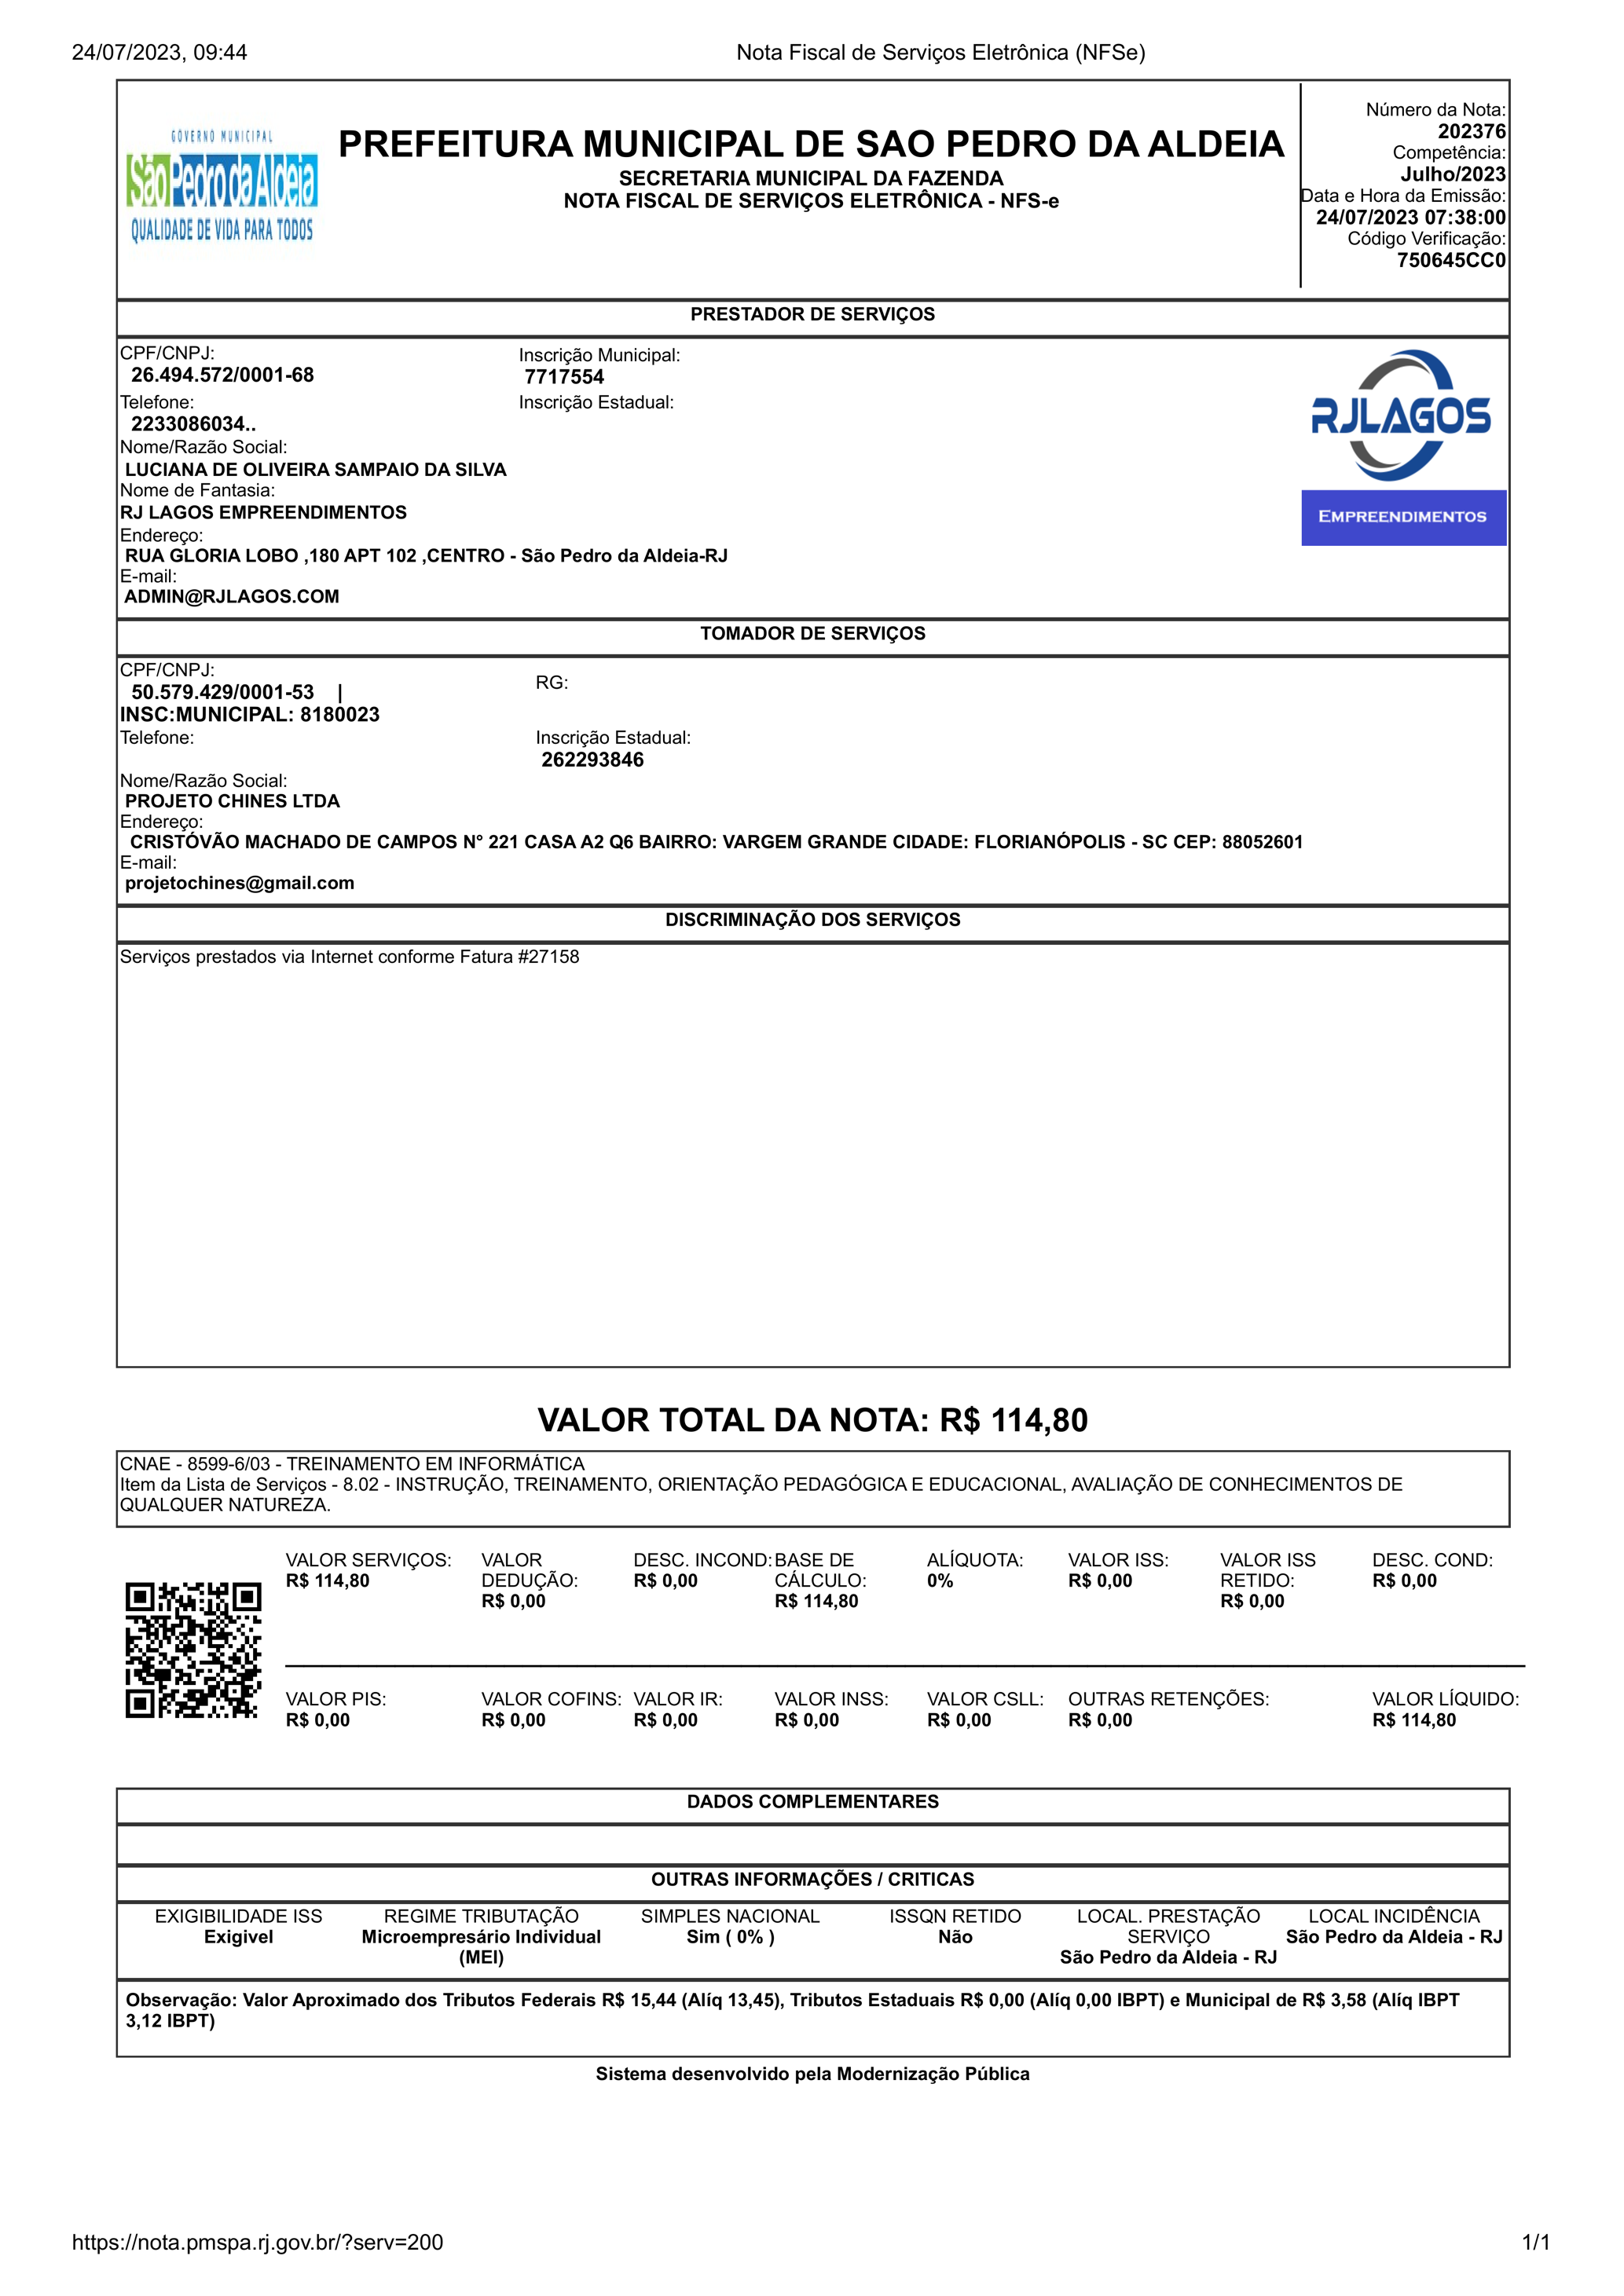

In [443]:
image_2work

In [446]:
# 6A. ZZZ Chamo pesquisaTextoDoc
document_text = pequisaTextoDoc(image_2work)
texto = texto_extraido_nf(document_text)
texto

['24/07/2028, 09:44 Nota Fiscal de Serviços Eletrônica (NFSe)',
 'Número da Nota:',
 'GOVERNO MUNICIPA 202376',
 '“== PREFEITURA MUNICIPAL DE SAO PEDRO DA ALDEIA Competência:',
 'Pero AR SECRETARIA MUNICIPAL DA FAZENDA Julho/2023',
 'OUT UU VOA NOTA FISCAL DE SERVIÇOS ELETRÔNICA - NFS-e BIOTIZOOS 07.35.00',
 'QUALIDADE DE VIDA PARA TODOS Código Verificação:',
 '750645CC0',
 'CPF/CNPJ: Inscrição Municipal: PN',
 '26.494.572/0001-68 7717554 ss',
 'Telefone: Inscrição Estadual:',
 '2233086034. RJLAGOS',
 'Nome/Razão Social: N',
 'LUCIANA DE OLIVEIRA SAMPAIO DA SILVA A',
 'Nome de Fantasia:',
 'RJ LAGOS EMPREENDIMENTOS EMPREENDIMENTOS',
 'Endereço:',
 'RUA GLORIA LOBO ,180 APT 102 CENTRO - São Pedro da Aldeia-RJ',
 'E-mail:',
 'ADMINQRJLAGOS.COM',
 'TOMADOR DE SERVIÇOS',
 'CPF/CNPJ: RG:',
 '50.579.429/0001-53 | :',
 'INSC:MUNICIPAL: 8180023',
 'Telefone: Inscrição Estadual:',
 '262293846',
 'Nome/Razão Social:',
 'PROJETO CHINES LTDA',
 'Endereço: | o',
 'CRISTÓVÃO MACHADO DE CAMPOS Nº 221

In [444]:
#6B. ZZZ Mesmo processo - porem chamando outra funcao de ajuste de texto 
document_text = pequisaTextoDoc(image_2work)
texto = texto_extraido(document_text)
texto

['24/07/2028, 0944 Nota Fiscal de Serviços Eletrônica (NFSe)',
 'Número da Nota',
 'GOVERNO MUNICIPA 202376',
 '“== PREFEITURA MUNICIPAL DE SAO PEDRO DA ALDEIA Competência',
 'Pero AR SECRETARIA MUNICIPAL DA FAZENDA Julho/2023',
 'OUT UU VOA NOTA FISCAL DE SERVIÇOS ELETRÔNICA - NFS-e BIOTIZOOS 07.35.00',
 'QUALIDADE DE VIDA PARA TODOS Código Verificação',
 '750645CC0',
 'CPF/CNPJ Inscrição Municipal PN',
 '26.494.572/0001-68 7717554 ss',
 'Telefone Inscrição Estadual',
 '2233086034. RJLAGOS',
 'Nome/Razão Social N',
 'LUCIANA DE OLIVEIRA SAMPAIO DA SILVA A',
 'Nome de Fantasia',
 'RJ LAGOS EMPREENDIMENTOS EMPREENDIMENTOS',
 'Endereço',
 'RUA GLORIA LOBO ,180 APT 102 CENTRO - São Pedro da Aldeia-RJ',
 'E-mail',
 'ADMINQRJLAGOS.COM',
 'TOMADOR DE SERVIÇOS',
 'CPF/CNPJ RG',
 '50.579.429/0001-53 |',
 'INSCMUNICIPAL 8180023',
 'Telefone Inscrição Estadual',
 '262293846',
 'Nome/Razão Social',
 'PROJETO CHINES LTDA',
 'Endereço | o',
 'CRISTÓVÃO MACHADO DE CAMPOS Nº 221 CASA A2 Q6 BAIRRO VAR

In [436]:
# 7. ZZZ Dicionário para mapear Prefeitura e/ou CNPJ para um template específico
templates = {
    ("PREFEITURA DA CIDADE MAGE", "30.693.231/0001-99"): "MAGE_MAICON",
    ("PREFEITURA DA CIDADE MAGE", "23.317.112/0001-76"): "MAGE_MFF",
    ("PREFEITURA DA CIDADE MAGE", None): "MAGE",
    ("PREFEITURA MUNICIPAL DE MAGE", None): "MAGE",
    ("PREFEITURA MUNICIPAL DE SAO PEDRO DA ALDEIA", "47.945.459/0001-21"): "SAO_PEDRO_GOAT",
    ("PREFEITURA MUNICIPAL DE SAO PEDRO DA ALDEIA", "68.687.722/0001-08"): "SAO_PEDRO_GM",
    ("PREFEITURA MUNICIPAL DE SAO PEDRO DA ALDEIA", None): "SAO_PEDRO",
    ("Pague agora com o seu Pix", None): "NAO_PROCESSAR",
    # ... adicione outras combinações aqui
}




# 8. ZZZ Consistencia para buscar modelo
prefeitura_encontrada = None
cnpj_encontrado = None

# Verifique cada linha do texto
for linha in texto:
    for pref, cnpj in templates.keys():
        if pref in linha:
            #print(linha)
            prefeitura_encontrada = pref
        if cnpj and cnpj in linha:
            cnpj_encontrado = cnpj

# Saímos do loop, agora vamos verificar qual template usar
if prefeitura_encontrada:
    template_usar = templates.get((prefeitura_encontrada, cnpj_encontrado))
    if not template_usar:
        template_usar = templates.get((prefeitura_encontrada, None), "Template Padrão")
else:
    template_usar = "Template Padrão"

print(f"O template a ser usado é: {template_usar}")

In [ ]:
def conv_filename_no_ext(title):
    
    # Divida o título em nome e extensão (mas ignore a extensão)
    name = title.rsplit('.', 1)[0] if '.' in title else title

    # Remova acentos e caracteres especiais do nome
    name = normalize('NFKD', name).encode('ASCII', 'ignore').decode('ASCII')
    
    # Substitua espaços e hífens por sublinhados
    filename = name.replace(' ', '_').replace('-', '_')

    # Remova quaisquer outros caracteres não alfanuméricos, exceto sublinhados
    filename = re.sub(r'[^\w_]', '', filename)

    # Converter para minúsculas
    filename = filename.lower()

    return filename 


# 1. Funcao de conversao e resize do documento
def convertResize(doc2convert, document_path, image_resized_path):
    
    """# 1. remocao do sufixo .pdf
    if doc2convert.split(".")[1].islower():
        nameImage= doc2convert.removesuffix(".pdf")
    else:
        nameImage= doc2convert.removesuffix(".PDF")"""
    
    # 2. construo um novo nome para o documento imagem
    image_resized_name = os.path.join(f'{image_resized_path}/{str(doc2convert)}.jpg')
    
    # 3. Conversao para imagem
    pages = convert_from_path(document_path, 500, poppler_path=poppler_path)
    
    # 4. Verifica se ha mais que uma pagina
    if len(pages) > 1:
        raise ValueError("Erro, documento com mais de uma página")
    else:
        # 5. Iterar pelas páginas e redimensionar
        resized_pages = []
        for page in pages:
            resized_page = page.resize((2067, 2923))
            resized_pages.append(resized_page)
            
        resized_pages[0].save(image_resized_name, 'JPEG')
        
    return resized_pages[0], image_resized_name


# Funcao de conversao e resize do documento
def convertResize_analise(nome_documento, document_path, image_resized_path):
    
    """# 1. remocao do sufixo .pdf
    if doc2convert.split(".")[1].islower():
        nameImage= doc2convert.removesuffix(".pdf")
    else:
        nameImage= doc2convert.removesuffix(".PDF")"""
    
    # 2. construo um novo nome para o documento imagem
    image_resized_name = os.path.join(f'{image_resized_path}/{str(nome_documento)}.jpg')
    
    # 3. Conversao para imagem
    pages = convert_from_path(document_path, 500, poppler_path=poppler_path)
    
    # 4. Verifica se ha mais que uma pagina
    if len(pages) > 1:
        raise ValueError("Erro, documento com mais de uma página")
    else:
        # 5. Iterar pelas páginas e redimensionar
        resized_pages = []
        for page in pages:
            resized_page = page.resize((2067, 2923))
            resized_pages.append(resized_page)
            
        resized_pages[0].save(image_resized_name, 'JPEG')
        
    return resized_pages[0], image_resized_name


# 2. Pesquisa prefeitura no documento
def pequisaModel(image_name):

    # 1. Definindo as coordenadas do frame
    x0 = 406
    y0 = 0
    x1= 1540
    y1 = 380

    # 2. Definir frame_image
    frame_image = image_name.crop((x0, y0, x1, y1))

    # 3. Extraia texto usando OCR com configuração de idioma padrão para este frame
    extracted_text_frame = pytesseract.image_to_string(frame_image, lang='por', config=tessdata_dir_config).strip()

    # 4. Divida o texto por nova linha e mantenha apenas a última parte (assume que o valor está sempre no final)
    values = extracted_text_frame.split('\n')

    # 5. Interacao para pesquisar prefeitura
    for value in values:
        nome_prefeitura_match = re.search(r'PREFEITURA (.+)', value)
        if nome_prefeitura_match:
            nome_prefeitura = "PREFEITURA " + nome_prefeitura_match.group(1) 
            return  nome_prefeitura  
             
        
def extract_text_from_coordinates(image, coordinates, config):
    x0, y0, x1, y1 = coordinates
    frame_image = image.crop((x0, y0, x1, y1))
    extracted_text = pytesseract.image_to_string(frame_image, lang='por', config=config).strip()
    return extracted_text  



   

# Outros

In [ ]:
def analisa_document(file_path):
    
    pdf_document = fitz.open(file_path)
    pages = pdf_document.pages() # generator object

    page_nro = []
    for page in pages:
        page_nro.append(page)
    if len(page_nro) > 1:
        try:
            # Extrair texto dentro do retângulo
            x0 = 0
            y0 = 4
            x1 = 800
            y1 = 800  # Ajuste este valor para delimitar a região vertical
            pagines = len(page_nro)
            if len(page_nro) > 1:
                i = 0
                for i in range(pagines):
                    page = page_nro[i]
                    text = page.get_text("text", clip=(x0, y0, x1, y1))
                    values = text.split('\n')
                    for value in values:
                        if "PREFEITURA MUNICIPAL" in value:
                            nfe_varias_paginas = True
                            nfe_uma_paginas = False
                            boleto_uma_paginas = False
                            
                            
                            print(f'i = {i} "Trata-se de uma NFe de mais de uma pagina\n\n{value}')
                            return 
                            break
                        elif "aponte a câmera" in value:
                            print(f'i = {i} provavelmente um boleto\n\n{value}')
                            break
                        else:
                            print("Nao sei!")
        except Exception as e:
            print(f"Erro ao abrir pagina do PDF: {e}")

    else:
        try:
            # Definir retângulo de interesse
            x0 = 0
            y0 = 4
            x1 = 800
            y1 = 800  # Ajuste este valor para delimitar a região vertical
            # Extrair texto dentro do retângulo
            text = page.get_text("text", clip=(x0, y0, x1, y1))
            if "PREFEITURA MUNICIPAL" in text:
                print("Trata-se de uma NFe de uma pagina apenas")
            elif '' in text:
                print("provavel RASTER PDF de uma pagina apenas")     
            else:
                print("Nao sei!")

        except Exception as e:
            print(f"Erro ao abrir pagina do PDF: {e}")    
        
    pdf_document.close() 

In [ ]:
# PDF com 2 paginas, mas documento na segunda pagina
path_analise = "pipeline_extracao_documentos/2_documentos_para_extracao/Batch_14/junto 2566 (11).pdf"

In [ ]:

resized_pages = []
for page in pages:
    resized_page = page.resize((2067, 2923))
    resized_pages.append(resized_page)
    resized_pages[0].save(image_resized_name, 'JPEG')
    
return resized_pages[0], image_resized_name

### Posicao do Texto

In [475]:
from PIL import Image
import pytesseract

In [ ]:
# 2. Pesquisa prefeitura no documento
def pequisaTextoDoc(image_name):

    # 1. Definindo as coordenadas do frame
    x0 = 0
    y0 = 0
    x1= 2066
    y1 = 2922

    # 2. Definir frame_image
    frame_image = image_name.crop((x0, y0, x1, y1))

    # 3. Extraia texto usando OCR com configuração de idioma padrão para este frame
    extracted_text_frame = pytesseract.image_to_string(frame_image, lang='por', config=tessdata_dir_config).strip()
    
    return extracted_text_frame 

In [ ]:
document_text = pequisaTextoDoc(image_2work)

In [ ]:
texto = texto_extraido_nf(document_text)
texto

In [476]:
# Carregar a imagem
image = image_2work

# Executar OCR com saída no formato TSV
tsv_output = pytesseract.image_to_data(image, lang='por', config=tessdata_dir_config, output_type='data.frame')

In [477]:
tsv_output

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,2067,2923,-1.000000,NaN
1,2,1,1,0,0,0,92,56,1878,2818,-1.000000,NaN
2,3,1,1,1,0,0,92,56,1878,2814,-1.000000,NaN
3,4,1,1,1,1,0,92,56,1365,26,-1.000000,NaN
4,5,1,1,1,1,1,92,56,144,24,60.055702,"24/07/2028,"
...,...,...,...,...,...,...,...,...,...,...,...,...
363,5,1,1,1,50,4,1067,2631,154,22,96.657333,Modernização
364,5,1,1,1,50,5,1230,2631,80,17,96.572807,Pública
365,4,1,1,1,51,0,93,2840,1877,34,-1.000000,NaN
366,5,1,1,1,51,1,93,2840,470,34,90.209442,https://nota.pmspa.rj.gov.br/?serv=200


In [497]:
string = 'TOTAL DA NOTA'

In [498]:
filtered_df = tsv_output[tsv_output['text'].str.contains(string, na=False, case=False)]

In [499]:
filtered_df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text


In [495]:
y_positions = filtered_df['top'].values

In [496]:
y_positions

array([  56,  245,  797, 1881, 1977])

In [489]:
# Filtrar as linhas onde o texto 
tomador_rows = tsv_output[tsv_output.text == string]
tomador_rows

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text


In [485]:
# Exibir as coordenadas y
for index, row in tomador_rows.iterrows():
    print(f"Posição y: {row['top']}")

Posição y: 797


In [471]:
texto

['24/07/2028, 09:44 Nota Fiscal de Serviços Eletrônica (NFSe)',
 'Número da Nota:',
 'GOVERNO MUNICIPA 202376',
 '“== PREFEITURA MUNICIPAL DE SAO PEDRO DA ALDEIA Competência:',
 'Pero AR SECRETARIA MUNICIPAL DA FAZENDA Julho/2023',
 'OUT UU VOA NOTA FISCAL DE SERVIÇOS ELETRÔNICA - NFS-e BIOTIZOOS 07.35.00',
 'QUALIDADE DE VIDA PARA TODOS Código Verificação:',
 '750645CC0',
 'CPF/CNPJ: Inscrição Municipal: PN',
 '26.494.572/0001-68 7717554 ss',
 'Telefone: Inscrição Estadual:',
 '2233086034. RJLAGOS',
 'Nome/Razão Social: N',
 'LUCIANA DE OLIVEIRA SAMPAIO DA SILVA A',
 'Nome de Fantasia:',
 'RJ LAGOS EMPREENDIMENTOS EMPREENDIMENTOS',
 'Endereço:',
 'RUA GLORIA LOBO ,180 APT 102 CENTRO - São Pedro da Aldeia-RJ',
 'E-mail:',
 'ADMINQRJLAGOS.COM',
 'TOMADOR DE SERVIÇOS',
 'CPF/CNPJ: RG:',
 '50.579.429/0001-53 | :',
 'INSC:MUNICIPAL: 8180023',
 'Telefone: Inscrição Estadual:',
 '262293846',
 'Nome/Razão Social:',
 'PROJETO CHINES LTDA',
 'Endereço: | o',
 'CRISTÓVÃO MACHADO DE CAMPOS Nº 221

### Iteraçoes

In [ ]:
i = 1
for root, dirs, files in os.walk(root_doc_analise):
    dir_name = os.path.basename(root)
    for file in files:
        if file.lower().endswith('.pdf'):
            doc2convert = file
            document_path_1 = os.path.join(root, file)
            pdf_document = fitz.open(document_path_1)

            pesquisavel, metadados, paginas = is_pdf_searchable_analise(document_path_1)
            realmente_pequisavel = confirma_pdf_pequisavel3(document_path_1)
            
            print(f'{i} | {dir_name} | doc: {file} | realm_pdf: {realmente_pequisavel} | pesquisavel?: {pesquisavel} | paginas: {paginas}\n')
            
            
            i += 1
            
            # if not pdf_realmente_pequisavel:
                #     print(f'\nTeste nro: {i} | doc: {file} | pdf?: {documento_pdf} | pesquisavel?: {pesquisavel} | paginas: {paginas}\n')
                #     processo = "PDF_Raster"
                    
                #     image_2work, name_image_2work = convertResizeAnalise_1page(file, document_path_1, image_resized_path)
                    
                #     secao = "1 - CABECALHO"
                #     try:
                #         nro_nota = 0
                #         data_cabecalho = {}
                #         data_cabecalho['secao'] = secao
                #         valor_dict = {}
                #         dados_prefeitura = {}
                #         f_frame_name = "1_frame_prefeitura_nf"
                #         # 1. funçao basica de modelo 
                #         texto = executa_model_frame(model, secao, f_frame_name)
                #         text_splited = texto.split('\n')
                        
                #         valor_dict = extract_prefeitura(model, f_frame_name, text_splited)
                #         if valor_dict:
                #             dados_prefeitura.update(valor_dict)
                #         valor = {}   
                #         f_frame_name = "1_frame_dados_nf"
                #         dadinho_dados_nf = {}
                #         # 1. funçao basica de modelo 
                #         texto = executa_model_frame(model, secao, f_frame_name)    
                #         text_splited = texto_extraido(texto)
                #         keyword_list = ['Número da Nota:', 'Competência:', 'Data e Hora da Emissão:', 'Código Verificação:']

                #         string_pesquisa = "Número da Nota:"
                #         texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)         
                #         dadinho_dados_nf['numero_nota_fiscal'] = texto
                #         nro_nota = texto
                        
                #         string_pesquisa = "Competência:"
                #         texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
                #         dadinho_dados_nf['competencia'] = texto
                        
                #         string_pesquisa = "ata e Hora da Emissão:"
                #         texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
                #         dadinho_dados_nf['dt_hr_emissao'] = texto
                        
                #         string_pesquisa = "Código Verificação:"
                #         texto = pesquisa_keyword(string_pesquisa, text_splited, keyword_list)
                #         dadinho_dados_nf['codigo_verificacao'] = texto
                        
                #         data_cabecalho.update(dados_prefeitura)
                #         data_cabecalho.update(dadinho_dados_nf)
                #     except Exception as e:
                #         erros_cabecalho = {}
                #         err_msg = f"Erro de processo cabecalho: {e}"
                #         erros['documento'] = file
                #         erros_cabecalho['secao'] = secao
                #         erros_cabecalho['erro'] = err_msg
                #         erros.update(erros_cabecalho)  

In [ ]:
i = 1
for root, dirs, files in os.walk(root_doc_analise):
    dir_name = os.path.basename(root)
    for file in files:
        if file.lower().endswith('.pdf'):
            doc2convert = file
            document_path_1 = os.path.join(root, file)
            pdf_document = fitz.open(document_path_1)

            pesquisavel, metadados, paginas = is_pdf_searchable_analise(document_path_1)
            if pesquisavel:
                realmente_pequisavel, page = confirma_pdf_pequisavel3(document_path_1)
                if not realmente_pequisavel:
                    print(f'{i} | {dir_name} | doc: {file} | realm_pdf: {realmente_pequisavel} - page: {page} | pesquisavel?: {pesquisavel} | paginas: {paginas}\n{document_path_1}\n')
            
            
            i += 1

In [113]:
image_2work, name_image_2work = convertResizeAnalise_1page(doc_2_conv, path_analise, image_resized_path)

In [115]:
name_image_2work

'pipeline_extracao_documentos/6_geral_administacao/images/processadas/nfse_4407.pdf.jpg'

In [116]:
nome_pref = pequisaModel(image_2work)

In [117]:
nome_pref

'PREFEITURA DA CIDADE MAGÉ'

Nao sei!
Nao sei!
i = 0 provavelmente um boleto

e aponte a câmera do seu aparelho para o QR code ao lado.
Nao sei!
Nao sei!
i = 1 "Trata-se de uma NFe de mais de uma pagina

PREFEITURA MUNICIPAL DE SAO PEDRO DA ALDEIA


In [66]:
def analisa_document(file_path):
    
    pdf_document = fitz.open(file_path)
    pages = pdf_document.pages() # generator object

    page_nro = []
    for page in pages:
        page_nro.append(page)
    if len(page_nro) > 1:
        try:
            # Extrair texto dentro do retângulo
            x0 = 0
            y0 = 4
            x1 = 800
            y1 = 800  # Ajuste este valor para delimitar a região vertical
            pagines = len(page_nro)
            if len(page_nro) > 1:
                i = 0
                for i in range(pagines):
                    page = page_nro[i]
                    text = page.get_text("text", clip=(x0, y0, x1, y1))
                    values = text.split('\n')
                    for value in values:
                        if "PREFEITURA MUNICIPAL" in value:
                            nfe_varias_paginas = True
                            nfe_uma_paginas = False
                            boleto_uma_paginas = False
                            
                            
                            print(f'i = {i} "Trata-se de uma NFe de mais de uma pagina\n\n{value}')
                            return 
                            break
                        elif "aponte a câmera" in value:
                            print(f'i = {i} provavelmente um boleto\n\n{value}')
                            break
                        else:
                            print("Nao sei!")
        except Exception as e:
            print(f"Erro ao abrir pagina do PDF: {e}")

    else:
        try:
            # Definir retângulo de interesse
            x0 = 0
            y0 = 4
            x1 = 800
            y1 = 800  # Ajuste este valor para delimitar a região vertical
            # Extrair texto dentro do retângulo
            text = page.get_text("text", clip=(x0, y0, x1, y1))
            if "PREFEITURA MUNICIPAL" in text:
                print("Trata-se de uma NFe de uma pagina apenas")
            elif '' in text:
                print("provavel RASTER PDF de uma pagina apenas")     
            else:
                print("Nao sei!")

        except Exception as e:
            print(f"Erro ao abrir pagina do PDF: {e}")    
        
    pdf_document.close() 

provavel RASTER PDF de uma pagina apenas


In [ ]:
pdf_document.close() 

In [83]:
page_number = 1

In [100]:
text

''

In [102]:



page = pdf_document[page_number]
    # Definir retângulo de interesse
x0 = 0
y0 = 4
x1 = 800
y1 = 800  # Ajuste este valor para delimitar a região vertical
# Extrair texto dentro do retângulo
text = page.get_text("text", clip=(x0, y0, x1, y1))


if "PREFEITURA MUNICIPAL" in text:
    print("Trata-se de uma NFe")
elif '' in text:
    print("provavel RASTER PDF")     
else:
    print("Nao sei!") 
    
pdf_document.close()       

provavel RASTER PDF


In [165]:
pdf_document.close() 

In [ ]:
    pdf_document = fitz.open(file_path)
    # Página do PDF  ATENCAO  (UNICA PAGINA)
    page_number = 0  # Defina o número da página que deseja analisar
    page = pdf_document[page_number]
    # Definir retângulo de interesse
    x0 = 0
    y0 = 4
    x1 = 600
    y1 = 200  # Ajuste este valor para delimitar a região vertical
    # Extrair texto dentro do retângulo
    text = page.get_text("text", clip=(x0, y0, x1, y1))
    if text:
       page_number = 0
       pdf_realmente_pequisavel = True
       #print(page_number)
    else:
       page_number = 1
       pdf_realmente_pequisavel = False
       #print(page_number)
    
    try:
        page = pdf_document[page_number]
        x0 = 0
        y0 = 0
        x1 = 600
        y1 = 110

        text = page.get_text("text", clip=(x0, y0, x1, y1))
        nf_data_cabecalho = Extc.extract_fields_cabecalho(text)
        
        if nf_data_cabecalho:
            pdf_realmente_pequisavel = True
        else:
            pdf_realmente_pequisavel = False
            
        pdf_document.close()

### Operacoes

In [43]:
# Para apagar arquivos PDF:Zone
for root, dirs, files in os.walk(root_doc_analise):
    folder_name = os.path.basename(root)
    
    for file in files:
        file_path = os.path.join(root, file)
        #print(file)
        if ":Zone" in file:
            file_to_delete = file_path
            os.remove(file_to_delete)
            #print(file, "termina, pode eliminar")

## PyMuPDF_examples

https://pymupdf.readthedocs.io/en/latest/the-basics.html#

In [223]:
import fitz

In [35]:
pymupdf_path = "pipeline_extracao_documentos/2_documentos_para_extracao/Batch_14/nf_688___consor_zadar__engetecnica_enza_1.pdf"

In [40]:
pymupdf_path = "pipeline_extracao_documentos/2_documentos_para_extracao/Batch_14/1001204/nf_688___consor_zadar__engetecnica_enza_1_anotado.pdf"

In [224]:
pymupdf_path = "Dev_Content/content_from_pdftool/PyMuPDF_examples/textbox-extraction/search.pdf"

In [233]:
pymupdf_path = "pipeline_extracao_documentos/2_documentos_para_extracao/15 Nota Fiscal Eletrônica - CUNHA Julho_anotada.pdf"

In [242]:
pymupdf_path = "Dev_Content/content_from_pdftool/PyMuPDF_examples/textbox-extraction/search.png"

In [252]:
pymupdf_path = "pipeline_extracao_documentos/2_documentos_para_extracao/Batch_14/1001204/nf_688___consor_zadar__engetecnica_enza_1_anotado.pdf"

In [258]:
pymupdf_path = "pipeline_extracao_documentos/2_documentos_para_extracao/Batch_14/nf_688___consor_zadar__engetecnica_enza_2_varias_anotacoes.pdf"

In [36]:
def make_text(words):
    """Return textstring output of get_text("words").

    Word items are sorted for reading sequence left to right,
    top to bottom.
    """
    line_dict = {}  # key: vertical coordinate, value: list of words
    words.sort(key=lambda w: w[0])  # sort by horizontal coordinate
    for w in words:  # fill the line dictionary
        y1 = round(w[3], 1)  # bottom of a word: don't be too picky!
        word = w[4]  # the text of the word
        line = line_dict.get(y1, [])  # read current line content
        line.append(word)  # append new word
        line_dict[y1] = line  # write back to dict
    lines = list(line_dict.items())
    lines.sort()  # sort vertically
    return "\n".join([" ".join(line[1]) for line in lines])

In [41]:
doc = fitz.open(pymupdf_path)  # any supported document type
page = doc[0]  # we want text from this page

In [42]:
page

page 0 of pipeline_extracao_documentos/2_documentos_para_extracao/Batch_14/1001204/nf_688___consor_zadar__engetecnica_enza_1_anotado.pdf

In [43]:
rect = page.first_annot.rect  # this annot has been prepared for us!
# Now we have the rectangle ---------------------------------------------------

print(page.get_textbox(rect))

In [44]:
rect = page.first_annot.rect

In [45]:
words = page.get_text("words")  # list of words on page

In [46]:
# ----------------------------------------------------------------------------
# Case 1: select the words *fully contained* in the rect
# ----------------------------------------------------------------------------
mywords = [w for w in words if fitz.Rect(w[:4]) in rect]

print("Select the words strictly contained in rectangle")
print("------------------------------------------------")
print(make_text(mywords))

Select the words strictly contained in rectangle
------------------------------------------------



In [47]:
# ----------------------------------------------------------------------------
# Case 2: select the words *intersecting* the rect
# ----------------------------------------------------------------------------
mywords = [w for w in words if fitz.Rect(w[:4]).intersects(rect)]

print("\nSelect the words intersecting the rectangle")
print("-------------------------------------------")
print(make_text(mywords))


Select the words intersecting the rectangle
-------------------------------------------



In [48]:
#-------------------------------------------------------------------------------
#Identify the rectangle.
#-------------------------------------------------------------------------------

rect = page.first_annot.rect  # this annot has been prepared for us!
# Now we have the rectangle ---------------------------------------------------

print(page.get_textbox(rect))

### Extracting tables

In [ ]:
"""
Browse a document with a wxPython GUI to extract tables
-------------------------------------------------------------------------------
License: GNU GPL V3
(c) 2018 Jorj X. McKie

Usage
-----
python wx-extract.py

Notes
-----
Uses the ParseTab.py file which is found in the current directory.

Description
-----------
A file selection dialog is displayed to pick a document. Then, the document's
first page is displayed. The controls in the dialog allow the following:

* Browse forward and backward.

* Jump to a specific page.

* Paint a rectangle on a page using the "New Rect" button. The selection can be
  fine-tuned by using the spin controls. Moving the rectangle around with the
  mouse is now supported as well.

* If pressing the "New Rect" button again or if leaving the page, the existing
  rectangle and columns will be removed.

* After a rectangle has been painted, the "New Col" button allows to paint
  columns into it. The columns are shown as vertical lines inside the rectangle,
  and changes can be undone by selecting a column and then changing its
  coordinates. A column is deleted by entering "0" or by changing its value to
  something else outside of the rectangle's left/right borders.

* After a column is painted, rectangles can be changed with the controls.
  Columns will not be affected by this, however, they will be deleted if leaving
  the rectangle area. In contrast, if a rectangle is moved with the mouse (hold
  down the left key) columns will be moved along with it.

* Any time after a rectangle has been painted, its text can be parsed by
  pressing the "Get Table" button. The current script just prints the table to
  STDOUT if doing this. Columns can also be added or deleted while repeatedly
  pressing this button to evaluate any differences.

Dependencies
------------
PyMuPDF v1.12.0, wxPython phoenix
"""

from __future__ import print_function
import fitz
import wx
import os
from ParseTab import ParseTab

try:
    from PageFormat import FindFit
except:

    def FindFit(*args):
        return "not implemented"


try:
    from icons import ico_pdf

    show_icon = True
except:
    show_icon = False


def getint(v):
    import types

    # extract digits from a string to form an integer
    try:
        return int(v)
    except ValueError:
        pass
    if not isinstance(v, types.StringTypes):
        return 0
    a = "0"
    for d in v:
        if d in "0123456789":
            a += d
    return int(a)


# start the wx application
app = None
app = wx.App()

cursor_hand = wx.Cursor(wx.CURSOR_HAND)
cursor_cross = wx.Cursor(wx.CURSOR_CROSS)
cursor_vert = wx.Cursor(wx.CURSOR_SIZENS)
cursor_norm = wx.Cursor(wx.CURSOR_DEFAULT)
bmp_from_buffer = wx.Bitmap.FromBuffer

# some abbreviations to get rid of those long pesky names ...
defPos = wx.DefaultPosition
defSiz = wx.DefaultSize
khaki = wx.Colour(240, 230, 140)


# ==============================================================================
# Define our dialog as a subclass of wx.Dialog.
# Only special thing is, that we are being invoked with a filename ...
# ==============================================================================
class PDFdisplay(wx.Dialog):
    def __init__(self, parent, filename):
        wx.Dialog.__init__(
            self,
            parent,
            id=wx.ID_ANY,
            title="Parse Tables in ",
            pos=defPos,
            size=defSiz,
            style=wx.CAPTION | wx.CLOSE_BOX | wx.DEFAULT_DIALOG_STYLE,
        )

        # ======================================================================
        # display an icon top left of dialog, append filename to title
        # ======================================================================
        if show_icon:
            self.SetIcon(ico_pdf.img.GetIcon())  # set a screen icon
        self.SetBackgroundColour(khaki)
        self.SetTitle(self.Title + filename)
        self.set_rectangle = False

        # ======================================================================
        # open the document with MuPDF when dialog gets created
        # ======================================================================
        self.doc = fitz.Document(filename)
        if self.doc.needs_pass:
            self.decrypt_doc()
        if self.doc.is_encrypted:
            self.Destroy()
            return
        # ======================================================================
        # forward button
        # ======================================================================
        self.BtnNext = wx.Button(
            self, wx.ID_ANY, "Forward", defPos, defSiz, wx.BU_EXACTFIT
        )
        # ======================================================================
        # backward button
        # ======================================================================
        self.BtnPrev = wx.Button(
            self, wx.ID_ANY, "Backward", defPos, defSiz, wx.BU_EXACTFIT
        )
        # ======================================================================
        # text field for entering a target page. wx.TE_PROCESS_ENTER is
        # required to get data entry fired as events.
        # ======================================================================
        self.TextToPage = wx.TextCtrl(
            self,
            wx.ID_ANY,
            "1",
            defPos,
            wx.Size(40, -1),
            wx.TE_PROCESS_ENTER | wx.TE_RIGHT,
        )
        # ======================================================================
        # displays total pages
        # ======================================================================
        self.statPageMax = wx.StaticText(
            self,
            wx.ID_ANY,
            "of " + str(self.doc.page_count) + " pages.",
            defPos,
            defSiz,
            0,
        )
        # ======================================================================
        # displays page format
        # ======================================================================
        self.paperform = wx.StaticText(self, wx.ID_ANY, "", defPos, defSiz, 0)
        # ======================================================================
        # activate rectangle drawing
        # ======================================================================
        self.BtnRect = wx.Button(
            self, wx.ID_ANY, "New Rect", defPos, defSiz, wx.BU_EXACTFIT
        )
        # ======================================================================
        # "Left" literal
        # ======================================================================
        self.statLeft = wx.StaticText(
            self, wx.ID_ANY, "Left:", defPos, wx.Size(50, -1), 0
        )
        # ======================================================================
        # modify rectangle left
        # ======================================================================
        self.CtrlLeft = wx.SpinCtrl(
            self,
            wx.ID_ANY,
            "0",
            defPos,
            wx.Size(50, -1),
            wx.SP_ARROW_KEYS | wx.TE_PROCESS_ENTER,
            0,
            999,
            0,
        )
        # ======================================================================
        # "Top" literal
        # ======================================================================
        self.statTop = wx.StaticText(
            self, wx.ID_ANY, "Top:", defPos, wx.Size(50, -1), 0
        )
        # ======================================================================
        # modify rectangle top
        # ======================================================================
        self.CtrlTop = wx.SpinCtrl(
            self,
            wx.ID_ANY,
            "0",
            defPos,
            wx.Size(50, -1),
            wx.SP_ARROW_KEYS | wx.TE_PROCESS_ENTER,
            0,
            999,
            0,
        )
        # ======================================================================
        # "Height" literal
        # ======================================================================
        self.statHeight = wx.StaticText(
            self, wx.ID_ANY, "Height:", defPos, wx.Size(50, -1), 0
        )
        # ======================================================================
        # modify rectangle Height
        # ======================================================================
        self.CtrlHeight = wx.SpinCtrl(
            self,
            wx.ID_ANY,
            "0",
            defPos,
            wx.Size(50, -1),
            wx.SP_ARROW_KEYS | wx.TE_PROCESS_ENTER,
            0,
            999,
            0,
        )
        # ======================================================================
        # "Width" literal
        # ======================================================================
        self.statWidth = wx.StaticText(
            self, wx.ID_ANY, "Width:", defPos, wx.Size(50, -1), 0
        )
        # ======================================================================
        # modify rectangle Width
        # ======================================================================
        self.CtrlWidth = wx.SpinCtrl(
            self,
            wx.ID_ANY,
            "0",
            defPos,
            wx.Size(50, -1),
            wx.SP_ARROW_KEYS | wx.TE_PROCESS_ENTER,
            0,
            999,
            0,
        )
        # ======================================================================
        # parse table within rectangle
        # ======================================================================
        self.BtnMatrix = wx.Button(
            self, wx.ID_ANY, "Get Table", defPos, defSiz, wx.BU_EXACTFIT
        )
        # ======================================================================
        # column controls
        # ======================================================================
        self.BtnNewCol = wx.Button(
            self, wx.ID_ANY, "New Col", defPos, defSiz, wx.BU_EXACTFIT
        )
        self.col_coords = {}
        self.ColList = wx.Choice(self, wx.ID_ANY, defPos, wx.Size(50, -1))
        self.CtrlCols = wx.SpinCtrl(
            self,
            wx.ID_ANY,
            "0",
            defPos,
            wx.Size(50, -1),
            wx.SP_ARROW_KEYS | wx.TE_PROCESS_ENTER,
            0,
            999,
            0,
        )
        # ======================================================================
        # image of document page
        # ======================================================================
        self.bitmap = self.pdf_show(1)
        self.PDFimage = wx.StaticBitmap(
            self, wx.ID_ANY, self.bitmap, defPos, self.bitmap.Size, wx.NO_BORDER
        )
        # ======================================================================
        # horizonzal lines
        # ======================================================================
        l1 = wx.StaticLine(self, wx.ID_ANY, defPos, defSiz, wx.LI_HORIZONTAL)
        l2 = wx.StaticLine(self, wx.ID_ANY, defPos, defSiz, wx.LI_HORIZONTAL)
        l3 = wx.StaticLine(self, wx.ID_ANY, defPos, defSiz, wx.LI_HORIZONTAL)

        """
        =======================================================================
        Overall Dialog Structure:
        -------------------------
        szr10 (main sizer for the whole dialog - vertical orientation)
        +-> szr20 (sizer for buttons etc. - horizontal orientation)
          +-> button forward
          +-> button backward
          +-> field for page number to jump to
          +-> field displaying total pages
          +-> fields for controlling the rectangle
        +-> szr30 (sizer for columns)
          +-> button "New Column"
          +-> fields for controlling a column
          +-> button to extract selected table
        +-> PDF image area
        =======================================================================
        """
        # ======================================================================
        # sizers
        # ======================================================================
        szr10 = wx.BoxSizer(wx.VERTICAL)  # main sizer
        szr20 = wx.BoxSizer(wx.HORIZONTAL)  # paging controls
        szr30 = wx.BoxSizer(wx.HORIZONTAL)  # rect & col controls & image
        szr40 = wx.BoxSizer(wx.VERTICAL)  # rect & col controls

        # szr20: navigation controls
        szr20.Add(self.BtnNext, 0, wx.ALL, 5)
        szr20.Add(self.BtnPrev, 0, wx.ALL, 5)
        szr20.Add(self.TextToPage, 0, wx.ALIGN_CENTER_VERTICAL | wx.ALL, 5)
        szr20.Add(self.statPageMax, 0, wx.ALIGN_CENTER_VERTICAL | wx.ALL, 5)
        szr20.Add(self.paperform, 0, wx.ALIGN_CENTER_VERTICAL | wx.ALL, 5)
        szr20.Fit(self)

        # szr40: rectangle & column controls
        szr40.Add(self.BtnRect, 0, wx.ALL, 5)
        szr40.Add(self.statLeft, 0, wx.ALL, 5)
        szr40.Add(self.CtrlLeft, 0, wx.ALL, 5)
        szr40.Add(self.statTop, 0, wx.ALL, 5)
        szr40.Add(self.CtrlTop, 0, wx.ALL, 5)
        szr40.Add(self.statHeight, 0, wx.ALL, 5)
        szr40.Add(self.CtrlHeight, 0, wx.ALL, 5)
        szr40.Add(self.statWidth, 0, wx.ALL, 5)
        szr40.Add(self.CtrlWidth, 0, wx.ALL, 5)
        szr40.Add(l2, 0, wx.EXPAND | wx.ALL, 5)
        szr40.Add(self.BtnNewCol, 0, wx.ALL, 5)
        szr40.Add(self.ColList, 0, wx.ALL, 5)
        szr40.Add(self.CtrlCols, 0, wx.ALL, 5)
        szr40.Add(l3, 0, wx.EXPAND | wx.ALL, 5)
        szr40.Add(self.BtnMatrix, 0, wx.ALL, 5)
        szr40.Fit(self)

        # szr30: document image
        szr30.Add(szr40, 0, wx.EXPAND, 5)
        szr30.Add(self.PDFimage, 0, wx.ALL, 5)
        szr30.Fit(self)

        # szr10: main sizer
        szr10.Add(szr20, 0, wx.EXPAND, 5)
        szr10.Add(l1, 0, wx.EXPAND | wx.ALL, 5)
        szr10.Add(szr30, 0, wx.EXPAND, 5)
        szr10.Fit(self)
        self.SetSizer(szr10)
        self.Layout()

        self.Centre(wx.BOTH)

        # ======================================================================
        # Bind event handlers
        # ======================================================================
        self.BtnNewCol.Bind(wx.EVT_BUTTON, self.AddCol)
        self.BtnNext.Bind(wx.EVT_BUTTON, self.NextPage)
        self.BtnPrev.Bind(wx.EVT_BUTTON, self.PreviousPage)
        self.TextToPage.Bind(wx.EVT_TEXT_ENTER, self.GotoPage)
        self.BtnRect.Bind(wx.EVT_BUTTON, self.ActivateRect)
        self.BtnMatrix.Bind(wx.EVT_BUTTON, self.GetMatrix)
        self.CtrlTop.Bind(wx.EVT_SPINCTRL, self.resize_rect)
        self.CtrlHeight.Bind(wx.EVT_SPINCTRL, self.resize_rect)
        self.CtrlLeft.Bind(wx.EVT_SPINCTRL, self.resize_rect)
        self.CtrlWidth.Bind(wx.EVT_SPINCTRL, self.resize_rect)
        self.CtrlCols.Bind(wx.EVT_SPINCTRL, self.UpdateCol)
        self.ColList.Bind(wx.EVT_CHOICE, self.OnColSelect)
        self.PDFimage.Bind(wx.EVT_LEFT_DOWN, self.OnLeftDown)
        self.PDFimage.Bind(wx.EVT_LEFT_UP, self.OnLeftUp)
        self.PDFimage.Bind(wx.EVT_MOTION, self.move_mouse)
        self.PDFimage.Bind(wx.EVT_MOUSEWHEEL, self.OnMouseWheel)
        self.disable_fields()

    def __del__(self):
        pass

    # ==============================================================================
    # Event handlers and other subroutines
    # ==============================================================================
    def cursor_in_rect(self, pos):
        # check whether cursor is in rectangle
        if self.rect_h <= 0 or self.rect_w <= 0:  # does a rect exist?
            return False
        if any(
            (
                pos.x < self.rect_x,
                pos.x > self.rect_x + self.rect_w,
                pos.y < self.rect_y,
                pos.y > self.rect_y + self.rect_h,
            )
        ):
            return False
        return True

    def rect_in_img(self, x, y, w, h):
        # check whether rectangle is inside page image
        width = self.PDFimage.Size[0]
        height = self.PDFimage.Size[1]
        if not (x >= 0 and y >= 0 and x + w <= width and y + h <= height):
            return False
        return True

    def disable_fields(self):
        # reset controls & buttons (e.g. b/o page scrolling)
        self.CtrlHeight.Disable()
        self.CtrlTop.Disable()
        self.CtrlLeft.Disable()
        self.CtrlWidth.Disable()
        self.ColList.Disable()
        self.CtrlCols.Disable()
        self.BtnMatrix.Disable()
        self.BtnNewCol.Disable()
        self.CtrlCols.Value = 0
        self.CtrlTop.Value = 0
        self.CtrlLeft.Value = 0
        self.CtrlHeight.Value = 0
        self.CtrlWidth.Value = 0
        self.set_rectangle = False
        self.col_selected = None
        self.adding_column = False
        self.dragging_rect = False
        self.col_coords = {}
        self.rect_x = 0
        self.rect_y = 0
        self.rect_w = 0
        self.rect_h = 0
        self.ColList.Clear()
        self.PDFimage.SetCursor(cursor_norm)
        return

    def enable_fields(self):
        # enable fields (after rectangle was made)
        self.BtnMatrix.Enable()
        self.CtrlHeight.Enable()
        self.CtrlTop.Enable()
        self.CtrlLeft.Enable()
        self.CtrlWidth.Enable()
        return

    def upd_collist(self):
        # update list of columns
        self.ColList.Clear()  # clear drop down list
        self.CtrlCols.Disable()  # disable spin control
        vlist = self.col_coords.values()
        if not vlist:  # no columns left?
            self.ColList.Disable()
            return
        self.ColList.Enable()  # else recreate column dict
        self.col_coords = {}
        vlist.sort()
        i = 1
        for v in vlist:
            if v > self.rect_x and v < self.rect_x + self.rect_w:
                cname = "Col" + str(i)
                self.col_coords[cname] = v
                self.ColList.Append(cname)
                i += 1

    def resize_rect(self, evt):
        # change rectangle shape via spin controls
        if self.CtrlWidth.Value < 5:
            self.CtrlWidth.Value = 5
        if self.CtrlHeight.Value < 5:
            self.CtrlHeight.Value = 5
        x = self.CtrlLeft.Value
        y = self.CtrlTop.Value
        w = self.CtrlWidth.Value
        h = self.CtrlHeight.Value
        # move no rectangle part outside page image
        if not self.rect_in_img(x, y, w, h):
            self.CtrlLeft.Value = self.rect_x  # reset invalid coordinates
            self.CtrlTop.Value = self.rect_y  # ...
            self.CtrlWidth.Value = self.rect_w  # ...
            self.CtrlHeight.Value = self.rect_h  # ...
            return
        self.rect_x = x
        self.rect_y = y
        self.rect_h = h
        self.rect_w = w
        self.DrawRect(x, y, w, h)  # redraw rectangle
        self.ColList.Clear()  # re-adjust column controls
        self.ColList.Disable()
        self.CtrlCols.Disable()
        self.CtrlCols.Value = 0
        self.col_selected = None
        self.upd_collist()
        for k in self.col_coords:  # also redraw all columns
            self.DrawColumn(self.col_coords[k], "RED")

    def move_rect(self, x, y, w, h):
        # move rectangle around with mouse
        if not self.rect_in_img(x, y, w, h):
            return  # no rect part outside image
        dx = x - self.rect_x  # remember horizontal movement delta
        self.rect_x = x
        self.rect_y = y
        self.CtrlLeft.Value = x
        self.CtrlTop.Value = y
        self.DrawRect(x, y, w, h)  # redraw rectangle
        self.CtrlCols.Value = 0  # set column info to
        self.ColList.Selection = -1  # none selected
        self.col_selected = None
        for k in self.col_coords:  # also redraw all columns after
            self.col_coords[k] += dx  # repositioning them
            self.DrawColumn(self.col_coords[k], "RED")

    def OnMouseWheel(self, evt):
        # process wheel as paging operations
        d = evt.GetWheelRotation()  # int indicating direction
        if d < 0:
            self.NextPage(evt)
        elif d > 0:
            self.PreviousPage(evt)
        return

    def OnColSelect(self, evt):
        # a column from the drop down box was selected
        self.adding_column = False
        col = evt.GetString()  # selected item
        self.CtrlCols.Value = self.col_coords[col]  # get its coord
        self.CtrlCols.Enable()  # enable spin control
        self.col_selected = col  # store selected string
        for k in self.col_coords:
            if k == col:
                self.DrawColumn(self.col_coords[k], "BLUE")
            else:
                self.DrawColumn(self.col_coords[k], "RED")

    def AddCol(self, evt):
        # insert new column into rectangle
        # change cursor to up-down image
        self.adding_column = True  # store state: adding column
        self.set_rectangle = False
        self.ColList.Enable()  # enable drop-down list
        self.CtrlCols.Disable()  # disable spin control
        self.col_selected = None  # state change: no column selected
        return

    def OnLeftDown(self, evt):
        # left mouse button pressed down
        pos = evt.GetPosition()
        if self.set_rectangle:  # about to make rectangle,
            self.rect_x = pos.x
            self.rect_y = pos.y
            return
        elif self.adding_column:  # about to make a column
            # horizontal coord must be within rectangle
            if not self.cursor_in_rect(pos):
                return
            # store new column info
            n = self.ColList.Count + 1
            col_name = "Col" + str(n)
            self.col_coords[col_name] = pos.x
            self.ColList.Append("Col" + str(n))
            self.CtrlCols.Value = pos.x
            self.adding_column = False  # reset state: not adding column
            self.DrawColumn(pos.x, "RED")  # draw the column
            return
        # potentially a rectangle drag request
        if self.cursor_in_rect(pos):
            self.dragging_rect = True
            self.dragstart_x = pos.x - self.rect_x  # delta cursor to left
            self.dragstart_y = pos.y - self.rect_y  # delta cursor to top
        return

    def OnLeftUp(self, evt):
        self.dragging_rect = False  # reset dragging information
        self.dragstart_x = 0
        self.dragstart_y = 0

        if not self.set_rectangle:  # out if not making a rectangle
            return
        self.PDFimage.SetCursor(cursor_norm)  # cursor default again
        pos = evt.GetPosition()
        self.rect_w = abs(pos.x - self.rect_x)  # get width
        self.rect_h = abs(pos.y - self.rect_y)  # get height
        if self.rect_x > pos.x:
            self.rect_x = pos.x  # recover from not painting ...
        if self.rect_y > pos.y:  # from top-left
            self.rect_y = pos.y  # to bottom-right
        self.enable_fields()  # enable fields
        self.set_rectangle = False  # reset state: no more making rect
        self.BtnNewCol.Enable()  # making columns now possible
        return

    def move_mouse(self, evt):
        # handle mouse movements
        pos = evt.GetPosition()
        if not (self.adding_column or self.set_rectangle):
            if self.cursor_in_rect(pos):  # only adjust cursor
                self.PDFimage.SetCursor(cursor_hand)
            else:
                self.PDFimage.SetCursor(cursor_norm)
        if self.adding_column:
            if self.cursor_in_rect(pos):
                self.PDFimage.SetCursor(cursor_vert)
            else:
                self.PDFimage.SetCursor(cursor_norm)
            return
        if self.set_rectangle and evt.LeftIsDown():  # if making a rectangle
            w = abs(pos.x - self.rect_x)
            h = abs(pos.y - self.rect_y)
            x = self.rect_x  # adjust coordinates ...
            if pos.x < x:  # if not ...
                x = pos.x  # moving from ...
            y = self.rect_y  # top-left to ...
            if pos.y < y:  # bottom-right ...
                y = pos.y  # direction
            self.rect_w = w
            self.rect_h = h
            self.CtrlHeight.Value = h  # update ...
            self.CtrlWidth.Value = w  # ... spin ...
            self.CtrlLeft.Value = x  # ... controls
            self.CtrlTop.Value = y
            self.DrawRect(x, y, w, h)  # draw rectangle
            return
        if not evt.LeftIsDown():
            self.dragging_rect = False
            self.dragstart_x = 0
            self.dragstart_y = 0
            return
        if self.dragging_rect and evt.LeftIsDown():
            new_x = pos.x - self.dragstart_x
            new_y = pos.y - self.dragstart_y
            self.move_rect(new_x, new_y, self.rect_w, self.rect_h)
            return
        return

    def UpdateCol(self, evt):
        # handle changes to spin control
        self.adding_column = False
        if not self.col_selected:  # only if a column is selected
            return
        v = self.CtrlCols.Value  # position of column
        x = self.rect_x  # rectangle coord's
        y = self.rect_y
        w = self.rect_w
        h = self.rect_h
        self.col_coords[self.col_selected] = v  # store col coord in dict
        if v <= x or v >= x + w:  # if col coord outside rectangle
            self.resize_rect(evt)  # delete the column
            self.ColList.SetFocus()  # focus to next col selection
            return  # and return
        self.DrawRect(x, y, w, h)  # else redraw everything we have
        for k in self.col_coords:  # redraw all columns
            if k == self.col_selected:
                c = "BLUE"
            else:
                c = "RED"
            self.DrawColumn(self.col_coords[k], c)

    def DrawColumn(self, x, c):
        # draw a vertical line
        dc = wx.ClientDC(self.PDFimage)  # make a device control out of img
        dc.SetPen(wx.Pen(c))
        # only draw inside the rectangle
        dc.DrawLine(x, self.rect_y, x, self.rect_y + self.rect_h)
        self.adding_column = False

    def DrawRect(self, x, y, w, h):
        # Draw a rectangle (red border, transparent interior)
        dc = wx.ClientDC(self.PDFimage)  # make a device control out of img
        dc.SetPen(wx.Pen("RED"))
        dc.SetBrush(wx.Brush("RED", style=wx.BRUSHSTYLE_TRANSPARENT))
        self.redraw_bitmap()
        dc.DrawRectangle(x, y, w, h)

    def GetMatrix(self, evt):
        # parse table contained in rectangle
        # currently, the table is just stored away as a matrix:
        # add functionality as desired
        x0 = self.rect_x
        y0 = self.rect_y
        x1 = x0 + self.rect_w
        y1 = y0 + self.rect_h
        cols = list(self.col_coords.values())
        cols.sort()
        pg = getint(self.TextToPage.Value) - 1
        self.parsed_table = ParseTab(self.doc[pg], [x0, y0, x1, y1], columns=cols)
        if self.parsed_table:
            r = len(self.parsed_table)
            c = len(self.parsed_table[0])
            t = "\nContents of (%s x %s)-table at [%s,%s] on page %s"
            print(t % (r, c, x0, y0, pg + 1))
            for l in self.parsed_table:
                print(l)
        else:
            print("No text found in rectangle")

    def redraw_bitmap(self):
        w = self.bitmap.Size[0]
        h = self.bitmap.Size[1]
        x = y = 0
        rect = wx.Rect(x, y, w, h)
        bm = self.bitmap.GetSubBitmap(rect)
        dc = wx.ClientDC(self.PDFimage)  # make a device control out of img
        dc.DrawBitmap(bm, x, y)  # refresh bitmap before draw
        return

    def ActivateRect(self, evt):
        # Start drawing a rectangle
        self.disable_fields()
        self.set_rectangle = True
        self.PDFimage.SetCursor(cursor_cross)

    def NextPage(self, event):  # means: page forward
        page = getint(self.TextToPage.Value) + 1  # current page + 1
        if page > self.doc.page_count:
            return
        page = min(page, self.doc.page_count)  # cannot go beyond last page
        self.TextToPage.Value = str(page)  # put target page# in screen
        self.bitmap = self.pdf_show(page)  # get page image
        self.NeuesImage(page)  # refresh the layout
        event.Skip()

    def PreviousPage(self, event):  # means: page back
        page = getint(self.TextToPage.Value) - 1  # current page - 1
        if page < 1:
            return
        page = max(page, 1)  # cannot go before page 1
        self.TextToPage.Value = str(page)  # put target page# in screen
        self.NeuesImage(page)
        event.Skip()

    def GotoPage(self, event):  # means: go to page number
        page = getint(self.TextToPage.Value)  # get screen page number
        page = min(page, self.doc.page_count)  # cannot go beyond last page
        page = max(page, 1)  # cannot go before page 1
        self.TextToPage.Value = str(page)  # make sure it's on the screen
        self.NeuesImage(page)
        event.Skip()

    # ==============================================================================
    # Read / render a PDF page. Parameters are: pdf = document, page = page#
    # ==============================================================================
    def NeuesImage(self, page):
        self.disable_fields()
        self.bitmap = self.pdf_show(page)  # read page image
        self.PDFimage.SetSize(self.bitmap.Size)  # adjust screen to image size
        self.PDFimage.SetBitmap(self.bitmap)  # put it in screen
        return

    def pdf_show(self, pg_nr):
        # get Pixmap of a page
        p = self.doc[pg_nr - 1]
        pix = p.get_pixmap(alpha=0)
        bitmap = bmp_from_buffer(pix.width, pix.height, pix.samples)
        self.paperform.Label = "Format: " + FindFit(pix.w, pix.h)
        return bitmap

    def decrypt_doc(self):
        # let user enter document password
        pw = None
        dlg = wx.TextEntryDialog(
            self,
            "Please enter password below:",
            "Document needs password to open",
            "",
            style=wx.TextEntryDialogStyle | wx.TE_PASSWORD,
        )
        while pw is None:
            rc = dlg.ShowModal()
            if rc == wx.ID_OK:
                pw = str(dlg.GetValue().encode("utf-8"))
                self.doc.authenticate(pw)
            else:
                return
            if self.doc.is_encrypted:
                pw = None
                dlg.SetTitle("Wrong password, enter correct one or cancel")
        return


# ==============================================================================
# main program
# ==============================================================================
# ==============================================================================
# Show a FileSelect dialog to choose a file
# ==============================================================================

# Wildcard: offer all supported filetypes
wild = "supported files|*.pdf;*.xps;*.oxps;*.epub;*.cbz"

# ==============================================================================
# define the file selection dialog
# ==============================================================================
dlg = wx.FileDialog(
    None,
    message="Choose a document",
    defaultDir=os.getcwd(),
    defaultFile="",
    wildcard=wild,
    style=wx.FD_OPEN | wx.FD_CHANGE_DIR,
)

In [ ]:
modules/extract-table/ParseTab.py

In [273]:
import modules.extract-table.ParseTab as parse

SyntaxError: invalid syntax (2496845495.py, line 1)

In [ ]:
Dev_Content/content_from_pdftool/PyMuPDF_examples/extract-table/ParseTab.py

In [ ]:
doc = fitz.open(pymupdf_path)  # any supported document type
page = doc[0]  # we want text from this page

"""
-------------------------------------------------------------------------------
Identify the rectangle.
-------------------------------------------------------------------------------
"""
rect = page.first_annot.rect  # this annot has been prepared for us!
# Now we have the rectangle ---------------------------------------------------

"""
Get all words on page in a list of lists. Each word is represented by:
[x0, y0, x1, y1, word, bno, lno, wno]
The first 4 entries are the word's rectangle coordinates, the last 3 are just
technical info (block number, line number, word number).
The term 'word' here stands for any string without space.
"""

words = page.get_text("words")  # list of words on page

"""
We will subselect from this list, demonstrating two alternatives:
(1) only words inside above rectangle
(2) only words insertecting the rectangle

The resulting sublist is then converted to a string by calling above funtion.
"""

# ----------------------------------------------------------------------------
# Case 1: select the words *fully contained* in the rect
# ----------------------------------------------------------------------------
mywords = [w for w in words if fitz.Rect(w[:4]) in rect]

print("Select the words strictly contained in rectangle")
print("------------------------------------------------")
print(make_text(mywords))

# ----------------------------------------------------------------------------
# Case 2: select the words *intersecting* the rect
# ----------------------------------------------------------------------------
mywords = [w for w in words if fitz.Rect(w[:4]).intersects(rect)]

print("\nSelect the words intersecting the rectangle")
print("-------------------------------------------")
print(make_text(mywords))

In [268]:
from __future__ import print_function
import fitz
from ParseTab import ParseTab

# ==============================================================================
# Main program
# ==============================================================================
""" This is just a stub to illustrate the functioning of ParseTab.
After reading a page, we
(1) search the strings that encapsulate our table
(2) from coordinates of those string occurences, we define the surrounding
    rectangle. We use zero or large numbers to specify "no limit".
(3) call ParseTab to get the parsed table
"""
doc = fitz.Document("input.pdf")
pno = 35
page = doc.load_page(pno)

# ==============================================================================
# search for top of table
# ==============================================================================
table_title = "2.9 Glossary"
search1 = page.search_for(table_title, hit_max=1)
if not search1:
    raise ValueError("table top delimiter not found")
rect1 = search1[0]  # the rectangle surrounding the search string
ymin = rect1.y1  # the table starts below this value

# ==============================================================================
# search for bottom of table
# ==============================================================================
search2 = page.search_for("2.10", hit_max=1)
if not search2:
    print("warning: table bottom delimiter not found - using end of page")
    ymax = 99999
else:
    rect2 = search2[0]  # the rectangle that surrounds the search string
    ymax = rect2.y0  # the table ends above this value

if not ymin < ymax:  # something went wrong with searching strings
    raise ValueError("table bottom delimiter higher than top")

# ==============================================================================
# print the table
# ==============================================================================
tab = ParseTab(page, [0, ymin, 9999, ymax])
print(table_title)
for t in tab:
    print(t)

ModuleNotFoundError: No module named 'ParseTab'

### PyMU examples

In [3]:
import sys, pathlib, fitz

In [4]:
fname = sys.argv[1]  # get document filename

In [31]:
doc_path = "pipeline_extracao_documentos/2_documentos_para_extracao/para_processamento/15 Nota Fiscal Eletrônica - CUNHA Julho.pdf"

In [17]:
doc_path = "Dev_Content/content_from_pdftool/PyMuPDF_examples/272519EC-959B-4460-BBE6-D80D272B9ACD.PDF"

In [8]:
doc_path = "Dev_Content/content_from_pdftool/PyMuPDF_examples/detect-hidden/nf_688___consor_zadar__engetecnica_enza_2_varias_anotacoes.pdf"

In [12]:
with fitz.open(doc_path) as doc:  # open document
    text = chr(12).join([page.get_text() for page in doc])

In [13]:
text

'PREFEITURA MUNICIPAL DE MESQUITA\n2023173\nNúmero da Nota:\nData e Hora de Emisssão:\nC64B104C7\nCódigo de Verificação:\nSECRETARIA MUNICIPAL DE FAZENDA\nMODERNIZACAO PUBLICA E INFORMATICA LTDA\nvm.direcao@yahoo.com.br\n(21) 3848-0080\n15.064.270/0001-33\n5000545\nE-mail:\nTelefone:\nCPF/CNPJ:\nInscrição Municipal:\nInscrição Estadual:\n01/08/2023 03:32:41\nNOTA FISCAL DE SERVIÇO ELETRÔNICA - NFS-e\nPRESTADOR DE SERVIÇOS\nNome/Razão Social:\nNome Fantasia: Modernização Pública\nEndereço:\nCompetência:\nJULHO/2023\nRUA PREFEITO JOSE MONTES PAIXAO, 1708 SOBRADO CENTRO MESQUITA/RJ CEP: 26553-161\nRPS Nº: 1386 SÉRIE: 1 | EMISSÃO: 01/08/2023\nPREF.MUN.DE SAO PEDRO DA ALDEIA\nCESSAO DE LICENCIAMENTO DE USO DE SOLUCAO PARA SISTEMA INTEGRADO DE GESTAO PUBLICA CONTRATO  94/2022, PR\nOCESSO 6699/2022 NOTA FISCAL REFERENTE AO MES 07/2023\n-  CREDITAR NO BANCO BRADESCO AG 6615 C/C 12311-0 OU BANCO DO BRASIL AG 1253-X C/C 125016-7 OU \nPIX: CNPJ 15.064.270/0001-33\nR$ 206.549,00\n28.909.604/0001-7

In [26]:
doc = fitz.open("pipeline_extracao_documentos/2_documentos_para_extracao/para_processamento/15 Nota Fiscal Eletrônica - CUNHA Julho.pdf")

In [27]:

header = "Header"  # text in header
footer = "Page %i of %i"  # text in footer
for page in doc:
    page.insert_text((50, 50), header)  # insert header
    page.insert_text(  # insert footer 50 points above page bottom
        (50, page.rect.height - 50),
        footer % (page.number + 1, doc.page_count),
    )

In [32]:
import sys

import fitz


def flags_decomposer(flags):
    """Make font flags human readable."""
    l = []
    if flags & 2 ** 0:
        l.append("superscript")
    if flags & 2 ** 1:
        l.append("italic")
    if flags & 2 ** 2:
        l.append("serifed")
    else:
        l.append("sans")
    if flags & 2 ** 3:
        l.append("monospaced")
    else:
        l.append("proportional")
    if flags & 2 ** 4:
        l.append("bold")
    return ", ".join(l)




In [33]:

doc = fitz.open(doc_path)
page = doc[0]

In [34]:

# read page text as a dictionary, suppressing extra spaces in CJK fonts
blocks = page.get_text("dict", flags=11)["blocks"]
for b in blocks:  # iterate through the text blocks
    for l in b["lines"]:  # iterate through the text lines
        for s in l["spans"]:  # iterate through the text spans
            print("")
            font_properties = "Font: '%s' (%s), size %g, color #%06x" % (
                s["font"],  # font name
                flags_decomposer(s["flags"]),  # readable font flags
                s["size"],  # font size
                s["color"],  # font color
            )
            print("Text: '%s'" % s["text"])  # simple print of text
            print(font_properties)


Text: '28/07/2023, 14:44'
Font: 'ArialMT' (sans, proportional), size 8, color #000000

Text: 'Nota Fiscal de Serviços Eletrônica (NFSe)'
Font: 'ArialMT' (sans, proportional), size 8, color #000000

Text: 'https://nfs-e.mage.rj.gov.br'
Font: 'ArialMT' (sans, proportional), size 8, color #000000

Text: '1/1'
Font: 'ArialMT' (sans, proportional), size 8, color #000000

Text: 'PREFEITURA MUNICIPAL DE MAGE'
Font: 'Arial-BoldMT' (sans, proportional, bold), size 13.5063, color #000000

Text: 'SECRETARIA MUNICIPAL DA FAZENDA'
Font: 'Arial-BoldMT' (sans, proportional, bold), size 7.50349, color #000000

Text: 'NOTA FISCAL DE SERVIÇOS ELETRÔNICA - NFS-e'
Font: 'Arial-BoldMT' (sans, proportional, bold), size 7.50349, color #000000

Text: 'Número da Nota:'
Font: 'ArialMT' (sans, proportional), size 6.75314, color #000000

Text: '15'
Font: 'Arial-BoldMT' (sans, proportional, bold), size 7.50349, color #000000

Text: 'Competência:'
Font: 'ArialMT' (sans, proportional), size 6.75314, color #000000



In [ ]:
# Importing necessary libraries to read and display the Jupyter Notebook
import nbformat

# Load the uploaded Jupyter Notebook file
notebook_path = '/mnt/data/1_Extruturacao_Pipeline_docs.ipynb'
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook_content = nbformat.read(f, as_version=4)

# Extract and display the titles of the cells to get an overview of the notebook's structure
cell_titles = []
for cell in notebook_content['cells']:
    if cell['cell_type'] == 'markdown':
        # Extracting titles and subtitles (lines starting with # or ##)
        for line in cell['source'].split('\n'):
            if line.startswith('#'):
                cell_titles.append(line.strip())

cell_titles[:10]  # Display the first 10 titles and subtitles to get an overview
